In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from numpy.random import normal

In [15]:
@njit(parallel=True)
def euler_Method(S0, interest_rate, delta_t, N, volatility):
    prev_S = S0
    stock_prices = np.empty(N)
    stock_prices[0] = S0
    for i in prange(1, N):  # Use prange for parallel execution
        Zm = normal()
        next_S = prev_S * (1 + interest_rate * delta_t + volatility * np.sqrt(delta_t) * Zm)
        prev_S = next_S
        stock_prices[i] = next_S
    return stock_prices

In [9]:
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.01
N = int(T/delta_t)


In [16]:
@njit(parallel=True)
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type="call"):
    pay_offs = np.empty(M)
    for i in prange(M):  # Use prange here as well for parallel execution
        stock_price_N = euler_Method(S0, r, delta_t, N, sigma)[-1]
        if option_type == "call":
            pay_off = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    price_option = np.exp(-r * T) * np.mean(pay_offs)
    return price_option

In [17]:
m = []
option_values = []
for M in np.arange(100, 10000, 50):
    option_value = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option value')

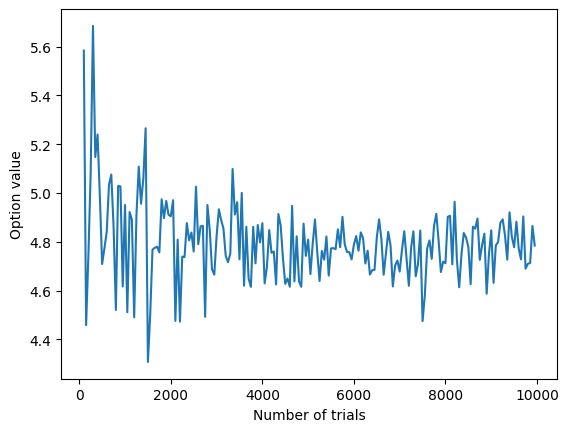

In [ ]:
plt.plot(m, option_values)
plt.xlabel("Number of trials")
plt.ylabel("Option value")

In [ ]:
## Varying strike price
K = np.arange(80, 120,2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 5000
N = int(T/delta_t)
option_values = []
for k in K:
    option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option Value')

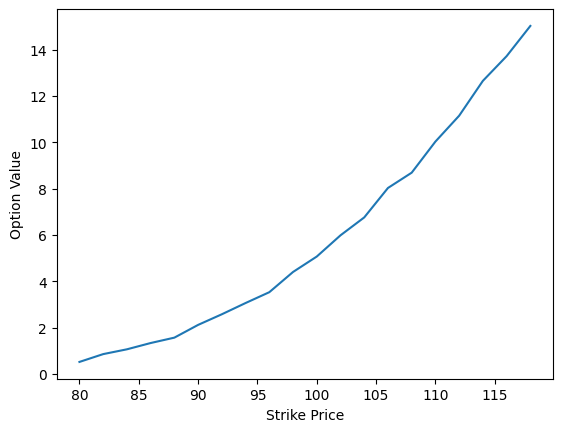

In [ ]:
##Plotting the option values
plt.plot(K, option_values)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")

In [ ]:
### Varying volatality
vols = np.arange(0.1, 0.5, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 5000
N = int(T/delta_t)
option_values = []
for vol in vols:
    option_value = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    m.append(M)
    option_values.append(option_value)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'norm':[0m [1m[1mCannot determine Numba type of <class 'scipy.stats._continuous_distns.norm_gen'>[0m
[1m
File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_25888\2430588692.py", line 6:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function euler_Method at 0x000001F5BD63C400>))[0m
[0m[1mDuring: typing of call at C:\Users\nitai\AppData\Local\Temp\ipykernel_25888\1624796878.py (5)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function euler_Method at 0x000001F5BD63C400>))[0m
[0m[1mDuring: typing of call at C:\Users\nitai\AppData\Local\Temp\ipykernel_25888\1624796878.py (5)
[0m
[1m
File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_25888\1624796878.py", line 5:[0m
[1m<source missing, REPL/exec in use?>[0m


Text(0, 0.5, 'Option Value')

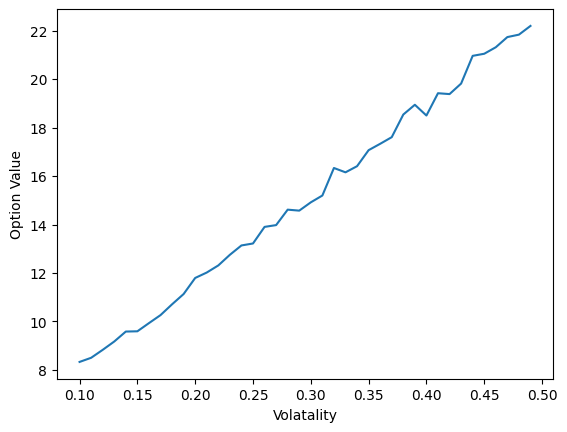

In [ ]:
##Plotting the option values
plt.plot(vols, option_values)
plt.xlabel("Volatality")
plt.ylabel("Option Value")


# Part 2: Black Scholes

### Helper fuctions

In [ ]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality):
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
    
    return option_price, norm.cdf(d1)

In [ ]:
def calc_delta_bump(option_price_array, bumped_option_price_array, bump_size):
    option_price_array = np.array(option_price_array)
    bumped_option_price_array = np.array(bumped_option_price_array)
    delta_est = (option_price_array - bumped_option_price_array)/bump_size
    return delta_est


In [ ]:
def digital_option_payoff(S0, K, type='call', position='long'):
    if type=='call':
        payoff = np.maximum(0, S0-K)
    elif type == 'put':
        payoff = np.maximum(0, K-S0)
    if position == 'long':
        return payoff
    elif position == 'short':
        return -1*payoff

In [ ]:
## Varying strike price
K = np.arange(80, 90,2)
K = np.arange(80, 90,2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 500
N = int(T/delta_t)
option_value_MC = []
option_value_MC_bumped = []
black_scholes_prices = []
bumps = [0.1,0,5,1,5,10,20]
# bumps = [0.1,0,5,1,5,10,20]

# for bump in bumps:
    for k in K:
        option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
        option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, k, M, "put")
        option_value_MC.append(option_value)
        option_value_MC_bumped.append(option_bumped)
        BS_option_price = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)
        black_scholes_prices.append(BS_option_price)
        black_scholes_delta.append
        abs_error_ = np.



In [ ]:
K = np.arange(80, 90,2)
T = 1.0
r = 0.06
S0 = 100 
K = 99
sigma = 0.2
delta_t = 0.001
M = 9000
N = int(T/delta_t)
bump = 1


option_value = priceOption(S0, r, delta_t, N, sigma, K, M, "call")
option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, K, M, "call")
delta_bump = (np.array(option_bumped) - np.array(option_value))/bump
BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[1]


print(f"Monte Carlo Delta: {delta_bump}")
print(f"Black-Scholes Delta: {BS_delta}")

KeyboardInterrupt: 

In [ ]:
## Varying strike price
K = np.arange(80, 90,2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 9000
N = int(T/delta_t)
option_value_MC = []
option_value_MC_bumped = []
black_scholes_prices = []
black_scholes_deltas = []
delta_bumped = []
# bumps = [0.1,0,5,1,5,10,20]
# bumps = [0.1,0,5,1,5,10,20]
bump = 0.01
K = 1
option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "call")
option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, k, M, "call")
option_value_MC.append(option_value)
option_value_MC_bumped.append(option_bumped)
delta_bump = (np.array(option_value_MC_bumped - np.array(option_value_MC)))/bump
delta_bumped.append(delta_bump)
BS_option_price = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[0]
black_scholes_prices.append(BS_option_price)
BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[1]
black_scholes_deltas.append(BS_delta)



In [ ]:
print(f"Monte Carlo Delta: {delta_bump}")
print(f"Black-Scholes Delta: {BS_delta}")

Monte Carlo Delta: [20.51729554]
Black-Scholes Delta: 1.0
